In [1]:
from datetime import datetime
 
from keras.layers import Embedding, LSTM, Dense, Conv1D, MaxPooling1D, Dropout, Activation
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
df_review = pd.read_csv("./reviewContent",names=["user_id","name","date","review"],sep='\t')
#df_review = pd.DataFrame(reviewContent)

df_metadata = pd.read_csv("./metadata",names=["user_id", "prod_id", "rating", "label", "date"],sep='\t')
#df_metadata = pd.DataFrame(metadata)

#reviewGraph = pd.read_table("reviewGraph",names=["user_id","name","rating1"])#,names=["user_id", "prod_id", "rating", "label", "date"])
#df_reviewGraph = pd.DataFrame(reviewGraph)

combine = pd.concat([df_review,df_metadata],axis=1,join="inner")#, join_axes=[df_reviewGraph.user_id])
combine = combine.dropna()
train = combine[["label","review"]] # add date later
train.head()

#merged = pd.merge(df_review,df_metadata,on= "user_id",how='inner')
#merged.head()

#len(train[train["label"]==-1])/
#len(train)

,label,review
0,-1,"Drinks were bad, the hot chocolate was watered..."
1,-1,This was the worst experience I've ever had a ...
2,-1,This is located on the site of the old Spruce ...
3,-1,I enjoyed coffee and breakfast twice at Toast ...
4,-1,I love Toast! The food choices are fantastic -...


In [3]:
# Make duplicates of negative samples to balance the data set
train1 = pd.concat([train[train["label"]==-1],train],axis=0)
train2 = pd.concat([train[train["label"]==-1],train1],axis=0)
train3 = pd.concat([train[train["label"]==-1],train2],axis=0)
#train4 = pd.concat([train[train["label"]==-1],train3],axis=0)
balanced_train = pd.concat([train[train["label"]==-1],train3],axis=0)

In [4]:
balanced_train = balanced_train.dropna()
balanced_train = balanced_train.reset_index(drop=True)
print('Shape of dataset ',balanced_train.shape)
print(balanced_train.columns)
print('No. of unique classes',len(set(balanced_train['label'])))

Shape of dataset  (930302, 2)
Index(['label', 'review'], dtype='object')
No. of unique classes 2


In [5]:
#change labels to id
macronum=sorted(set(balanced_train['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))


def fun(i):
    return macro_to_id[i]

pd.set_option('mode.chained_assignment',None)
balanced_train.iloc[:,0]=balanced_train.iloc[:,0].apply(fun)

In [6]:
# a list contains each review as a list 
balanced_texts = []
balanced_labels = []

for i in range(len(balanced_train)):
    balanced_texts.append(balanced_train.iloc[i,1])
    balanced_labels.append(balanced_train.iloc[i,0])

In [2]:
from six.moves import cPickle as pickle
import os
"""Save"""
cur_wd = os.getcwd()
pickle_file = os.path.join(cur_wd, 'save.pickle')

try:
    f = open(pickle_file, 'wb')
    save = {
        'balanced_texts': balanced_texts,
        'balanced_labels': balanced_labels
    }
    
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Unable to save data to /home/nhumair/data_mining/Data-MIning/save.pickle : name 'balanced_texts' is not defined


NameError: name 'balanced_texts' is not defined

In [4]:
# Load from pickle file
pickle_file = 'save.pickle'
with open(pickle_file, 'rb') as f :
    save = pickle.load(f)
    balanced_texts = save['balanced_texts']
    balanced_labels = save['balanced_labels']
    del save  # hint to help gc free up memory

EOFError: Ran out of input

In [ ]:
# Convulotional model1

In [7]:
#choose the first 20000 common words and set vector size as 500
# this step format text samples and labels into tensors that can be fed into a neural network with keras utilities
tokenizer = Tokenizer(num_words=20000)#20000
tokenizer.fit_on_texts(balanced_texts)
sequences = tokenizer.texts_to_sequences(balanced_texts)
data = pad_sequences(sequences, maxlen=500)#300

In [8]:
from keras.utils import to_categorical
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
labels = to_categorical(np.asarray(balanced_labels))
#labels = np.array(balanced_labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 204757 unique tokens.
Shape of data tensor: (930302, 500)
Shape of label tensor: (930302, 2)


In [9]:
# global vector word embedding
import os
embeddings_index = {}
cur_dir = os.getcwd()
f = open(os.path.join(cur_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [10]:
#prepare embedding matrix
EMBEDDING_DIM = 100
#num_words = min(20000, len(word_index)) + 1
#embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
'''
for word, i in word_index.items():
    if i > 20000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
'''
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [11]:
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
from keras.initializers import Constant


MAX_SEQUENCE_LENGTH = 500
#embedding_layer = Embedding(num_words,EMBEDDING_DIM,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_SEQUENCE_LENGTH,trainable=False)
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)


In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(0.2 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]


In [13]:
# train a 1D convnet with global maxpooling
from keras.layers import Input, GlobalMaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Dropout(0.2)(embedded_sequences)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(macronum), activation='sigmoid')(x)
#preds = Dense(2, activation='softmax')(x)

model = Model(sequence_input, preds)


def focal_loss(gamma=0., alpha=4.):
    gamma = float(gamma)
    alpha = float(alpha)
    
    def focal_loss_fixed(y_true,y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true,tf.float32)
        y_pred = tf.convert_to_tensor(y_pred,tf.float32)
        model_out = tf.add(y_pred,epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true,tf.pow(tf.subtract(1.,model_out),gamma))
        fl = tf.multiply(alpha, tf.multiply(weight,ce))
        reduced_fl = tf.reduce_max(fl,axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed
# if u previously saved model weights by checkpoint
# # load weights
#model.load_weights("weights.best.hdf5")
from keras import optimizers
#opt = optimizers.adam(lr=0.0008)
#model.compile(loss=focal_loss(alpha=1),optimizer='adam',metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()
#cp=ModelCheckpoint('model_cnn_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)


# split data into training and testing sets
#_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 100)          20475800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 496, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 99, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 95, 128)           82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 19, 128)           0         
__________

In [ ]:
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
validation_data=(x_val, y_val))


In [17]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9166
Validation Accuracy:  0.8431


In [18]:
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score
model_pred = model.predict(x_val,batch_size=200)
print(y_val)
print(model_pred)
print("accuracy_score ",accuracy_score(y_val,model_pred > 0.5, normalize=True, sample_weight=None))
model_pred_new = np.argmax(model_pred, axis=1)
class_pred = binarize(model_pred,threshold=0.5)

[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
[[4.9827865e-04 9.9999452e-01]
 [6.8243814e-01 3.6865801e-01]
 [6.3743192e-01 4.0835342e-01]
 ...
 [1.7155610e-01 9.6969754e-01]
 [5.7092328e-03 9.9517399e-01]
 [9.9931908e-01 4.6219765e-03]]
accuracy_score  0.8213318284424379


In [19]:
from sklearn.metrics import f1_score
print("Report for CNN models:")
#print(classification_report(y_val, class_pred))

#print("Accuracy for lr % :",metrics.accuracy_score(y_val, model_pred)*100)
#print("f1-score ",f1_score(y_val, model_pred > 0.5, average='samples',labels=np.unique(model_pred)))
print("f1-score ",f1_score(y_val, model_pred > 0.5, average='samples'))

Report for CNN models:
f1-score  0.8416084417213084


/home/nhumair/.conda/envs/my_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [20]:
print("Confusion Matric: ")
confusion_matrix(y_val.argmax(axis=1),model_pred.argmax(axis=1))

Confusion Matric: 


array([[75317,  5193],
       [24000, 81550]])

In [21]:
print("Classification Report ")
print(classification_report(y_val, model_pred > 0.5))

Classification Report 
              precision    recall  f1-score   support

           0       0.75      0.94      0.83     80510
           1       0.94      0.79      0.85    105550

   micro avg       0.83      0.85      0.84    186060
   macro avg       0.84      0.86      0.84    186060
weighted avg       0.85      0.85      0.84    186060
 samples avg       0.84      0.85      0.84    186060



/home/nhumair/.conda/envs/my_env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


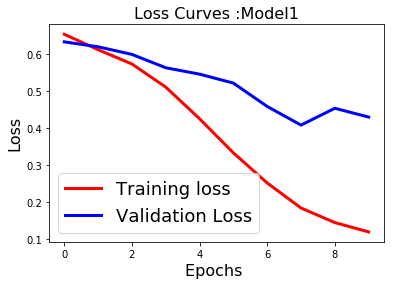

In [24]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :Model1',fontsize=16)
fig1.savefig('loss_model1.png')
plt.show()

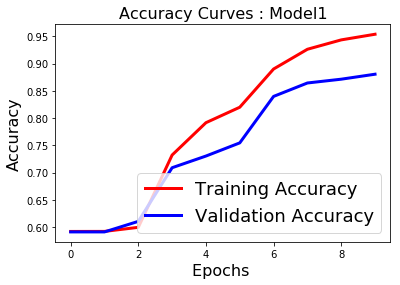

In [25]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : Model1',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='cnn_model_1.png', show_shapes=True, show_layer_names=True)
#from PIL import Image
#display(Image.open('cnn_model.png'))

In [ ]:
#first model

In [41]:
from keras.layers import Bidirectional

In [45]:
# build model and add layers
model = Sequential()
model.add(Embedding(20000, 128, input_length=500))#20000 300
model.add(Dropout(0.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(len(macronum), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, np.array(balanced_labels), test_size=0.3)

In [43]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
file_path = "./checkpoints/CLASSIFIER_epoch{epoch:02d}-loss{loss:.4f}-" \
            "acc{acc:0.4f}-val_loss{val_loss:0.4f}-val_acc{val_acc:0.4f}"
checkpoint = ModelCheckpoint(file_path,monitor="val_acc",save_best_only=True)
early_stopping = EarlyStopping(monitor="val_acc",patience=10)
callbacks_list = [checkpoint, early_stopping]

In [ ]:
# fit model
#model.fit(data, np.array(balanced_labels), validation_split=0.4, batch_size=200, epochs=150)
#history = model.fit(X_train,y_train,batch_size=200,callbacks= callbacks_list,validation_split=0.4,epochs=10)
model.summary()
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          2560000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 128)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 496, 64)           41024     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 514       
Total params: 2,799,170
Trainable params: 2,799,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

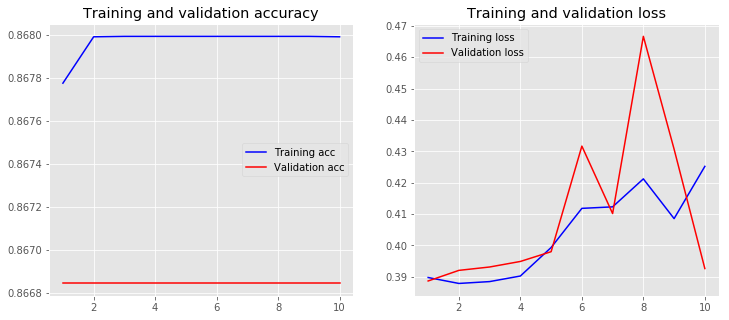

In [17]:
'''
visualize the loss and accuracy for the training and testing data based on the History callback. 
This callback, which is automatically applied to each Keras model, records the loss and additional metrics that can be added in the .fit() method. 
In this case, we are only interested in the accuracy.
'''
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig("training_validation_loss-accuracy_2.png")
    
plot_history(history)

In [ ]:
#hierarchical attention model2  with hidden_config_two

In [6]:
from nltk import tokenize
import re
from keras.preprocessing.text import text_to_word_sequence
import nltk
nltk.download('punkt')
#parameters for hierarchical attention network
MAX_SENT_LENGTH = 100
MAX_SENTS = 15
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
"""
train_han = train.dropna()
train_han =train_han.reset_index(drop=True)
print('Shape of dataset ',train_han.shape)
print(train_han.columns)
print('No. of unique classes',len(set(train_han['label'])))


macronum=sorted(set(train_han['label']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))


def fun(i):
    return macro_to_id[i]

pd.set_option('mode.chained_assignment',None)
train_han.iloc[:,0]=train_han.iloc[:,0].apply(fun)
# a list contains each review as a list 
#balanced_texts = []
#balanced_labels = []

#for i in range(len(train)):
   # balanced_texts.append(balanced_train.iloc[i,1])
   # balanced_labels.append(balanced_train.iloc[i,0])
"""
texts = []
labels = []
reviews = []

def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

for i in range(balanced_train.review.shape[0]):
    #text = BeautifulSoup(df.message[i])
    text=clean_str(balanced_train.iloc[i,1].lower())
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

"""
for i in range(len(balanced_train)):
    labels.append(i)
"""

[nltk_data] Downloading package punkt to /home/nhumair/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'\nfor i in range(len(balanced_train)):\n    labels.append(i)\n'

In [7]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts),MAX_SENTS, MAX_SENT_LENGTH), dtype= 'int32')


In [8]:
for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTS:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                try:
                    if k < MAX_SENT_LENGTH and tokenizer.word_index[word] < MAX_NB_WORDS:
                        data[i,j,k] = tokenizer.word_index[word]
                        k = k+1
                except KeyError:
                    pass

In [9]:
word_index = tokenizer.word_index
print('No of %s unique tokens.' % len(word_index))

No of 189860 unique tokens.


In [10]:
from keras.utils.np_utils import to_categorical
labels = []
for i in balanced_train['label']:
    labels.append(i)
labels_n = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of data tensor:', labels_n.shape)

Shape of data tensor: (930302, 15, 100)
Shape of data tensor: (930302, 2)


In [11]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels_n = labels_n[indices]
nb_validation_samples = int(0.2 * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels_n[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels_n[-nb_validation_samples:]


In [12]:
import os
embeddings_index = {}
cur_dir = os.getcwd()
f = open(os.path.join(cur_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
#prepare embedding matrix
EMBEDDING_DIM = 100
#num_words = min(20000, len(word_index)) + 1
#embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
'''
for word, i in word_index.items():
    if i > 20000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
'''
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SENT_LENGTH,trainable=False)


In [14]:
from keras.layers import Input, Bidirectional, TimeDistributed, Flatten, Dense
from keras.models import Model
sentence_input = Input(shape=(MAX_SENT_LENGTH,), dtype = 'int32')
embedded_sequences = embedding_layer(sentence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
sentEncoder = Model(sentence_input, l_lstm)

review_input = Input(shape = (MAX_SENTS,MAX_SENT_LENGTH), dtype='int32')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(LSTM(100))(review_encoder)
preds = Dense(len(macronum),activation='softmax')(l_lstm_sent)
model = Model(review_input, preds)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 200)           19146900  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 19,388,102
Trainable params: 402,002
Non-trainable params: 18,986,100
_________________________________________________________________


In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='han_model_2.png', show_shapes=True, show_layer_names=True)


ImportError: No module named 'PIL'

In [ ]:
history = model.fit(x_train,y_train, validation_data = (x_val, y_val),epochs=10,batch_size=128)

Train on 744242 samples, validate on 186060 samples
Epoch 1/10
744242/744242 [==============================] - 4739s 6ms/step - loss: 0.6733 - acc: 0.5776 - val_loss: 0.6670 - val_acc: 0.5836
Epoch 2/10
744242/744242 [==============================] - 4746s 6ms/step - loss: 0.6601 - acc: 0.5924 - val_loss: 0.6554 - val_acc: 0.5981
Epoch 3/10
744242/744242 [==============================] - 4760s 6ms/step - loss: 0.6341 - acc: 0.6217 - val_loss: 0.6350 - val_acc: 0.6160
Epoch 4/10
744242/744242 [==============================] - 4760s 6ms/step - loss: 0.5899 - acc: 0.6621 - val_loss: 0.6009 - val_acc: 0.6508
Epoch 5/10
744242/744242 [==============================] - 4761s 6ms/step - loss: 0.5332 - acc: 0.7083 - val_loss: 0.5636 - val_acc: 0.6837
Epoch 6/10
394752/744242 [==============>...............] - ETA: 34:37 - loss: 0.4792 - acc: 0.7488

In [19]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_val, y_val, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

KeyboardInterrupt: 

In [20]:
from sklearn.preprocessing import binarize
from sklearn.metrics import accuracy_score
model_pred = model.predict(x_val,batch_size=200)
print(y_val)
print(model_pred)
print("accuracy_score ",accuracy_score(y_val,model_pred > 0.5, normalize=True, sample_weight=None))
model_pred_new = np.argmax(model_pred, axis=1)
class_pred = binarize(model_pred,threshold=0.5)

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]
[[9.66124833e-01 3.38751301e-02]
 [1.04766674e-01 8.95233274e-01]
 [6.35437027e-05 9.99936461e-01]
 ...
 [7.90754257e-07 9.99999166e-01]
 [4.35532536e-03 9.95644689e-01]
 [9.95888412e-01 4.11157124e-03]]
accuracy_score  0.7952380952380952


In [21]:
from sklearn.metrics import f1_score
print("f1-score ",f1_score(y_val, model_pred > 0.5, average='samples'))

f1-score  0.7952380952380952


In [22]:
print("Confusion Matric: ")
confusion_matrix(y_val.argmax(axis=1),model_pred.argmax(axis=1))

Confusion Matric: 


array([[67479, 13038],
       [25060, 80483]])

In [23]:
print("Classification Report ")
print(classification_report(y_val, model_pred > 0.5))

Classification Report 
              precision    recall  f1-score   support

           0       0.73      0.84      0.78     80517
           1       0.86      0.76      0.81    105543

   micro avg       0.80      0.80      0.80    186060
   macro avg       0.79      0.80      0.79    186060
weighted avg       0.80      0.80      0.80    186060
 samples avg       0.80      0.80      0.80    186060



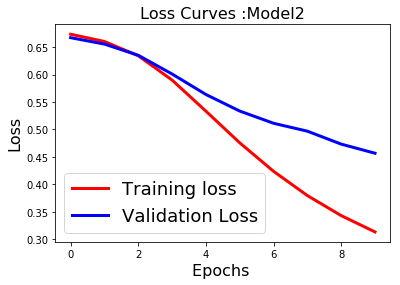

In [24]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :Model2',fontsize=16)
fig1.savefig('loss_model2.png')
plt.show()

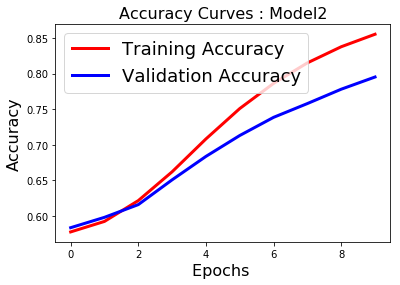

In [25]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : Model2',fontsize=16)
fig2.savefig('accuracy_cnn_2.png')
plt.show()

In [ ]:
##################### data generator attempst ###########################

In [8]:
words =set()
for l in data:

        words = words.union(set(l))

words = sorted(words)

print('Unique words:', len(words))

Unique words: 20000


In [9]:
word_indices = dict((c, i) for i, c in enumerate(words))

indices_word = dict((i, c) for i, c in enumerate(words))

In [11]:
#keras pad_sequences return Numpy array with shape (len(sequences), maxlen)

# Data generator for fit and evaluate

def generator(sentence_list, labels_list, batch_size):

    index = 0

    while True:

        x = np.zeros((batch_size, 500), dtype=np.object)

        y = np.zeros((batch_size), dtype=np.int64)

        for i in range(batch_size):

            for t, w in enumerate(sentence_list[index % len(sentence_list)]):

                x[i, t] = word_indices[w]

            y[i] = labels_list[index % len(sentence_list)]

            index = index + 1

        yield x, y


model.fit_generator(generator(X_train, y_train, 200),

                        steps_per_epoch=int(len(X_train)/200) + 1,

                        epochs=10,
                        callbacks= callbacks_list,

                        validation_data=generator(X_test, y_test, 200),

                        validation_steps=int(len(X_test)/200) + 1)

Epoch 1/3
2130/2130 [==============================] - 566s 266ms/step - loss: 0.5388 - acc: 0.8496 - val_loss: 0.5668 - val_acc: 0.8672
Epoch 2/3
2130/2130 [==============================] - 556s 261ms/step - loss: 0.4539 - acc: 0.7824 - val_loss: 0.5802 - val_acc: 0.8292
Epoch 3/3
2130/2130 [==============================] - 556s 261ms/step - loss: 0.2883 - acc: 0.7888 - val_loss: 0.6165 - val_acc: 0.7862


In [26]:
for i in range(len(class_pred)):
    if class_pred[i].any() == False:
        
        class_pred[i] = -1

In [ ]:
#evaluate the model
from sklearn.model_selection import StratifiedKFold
seed = 7
np.random.seed(seed)

kfold = StratifiedKFold(n_splits=10,shuffle=True,random_state=seed)

cvscores = []

for train,test in kfold.split(data, np.array(balanced_labels)):
    model = Sequential()
    model.add(Embedding(20000, 128, input_length=500))#20000 300
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=4))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(data[train], np.array(balanced_labels)[train],batch_size=10,validation_split=0.4,epochs=10)
    #model.fit(data[train], np.array(balanced_labels)[train], batch_size=10, epochs=150)
    scores = model.evaluate(data[test], np.array(balanced_labels)[test], verbose=0)
    print(model.metrics_names)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))


Epoch 1/3
42593/42593 [==============================] - 7566s 178ms/step - loss: 0.5958 - acc: 0.8522 - val_loss: 0.5939 - val_acc: 0.8678
Epoch 2/3
42593/42593 [==============================] - 7746s 182ms/step - loss: 0.5968 - acc: 0.8550 - val_loss: 0.5773 - val_acc: 0.8678
Epoch 3/3
42593/42593 [==============================] - 7757s 182ms/step - loss: 0.5888 - acc: 0.8534 - val_loss: 0.5793 - val_acc: 0.8677
['loss', 'acc']
acc: 86.78%
Epoch 1/3
 6400/42593 [===>..........................] - ETA: 1:44:25 - loss: 0.6739 - acc: 0.8169